In [40]:
%load_ext autoreload
%autoreload 2

In [41]:
import numpy as np
import sys
sys.path
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/graspologic')

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

# Proof sparse works

In [9]:
n_verts = 100
labels_sbm = n_verts * [0] + n_verts * [1]
P = np.array([[0.8, 0.2], [0.2, 0.8]])
undirected_sbm = sbm(2 * [n_verts], P)
# heatmap(undirected_sbm, title='2-block SBM (undirected)', inner_hier_labels=labels_sbm)
directed_sbm = sbm(2 * [n_verts], P, directed=True)
# heatmap(directed_sbm, title='2-block SBM (directed)', inner_hier_labels=labels_sbm)

## normal ase

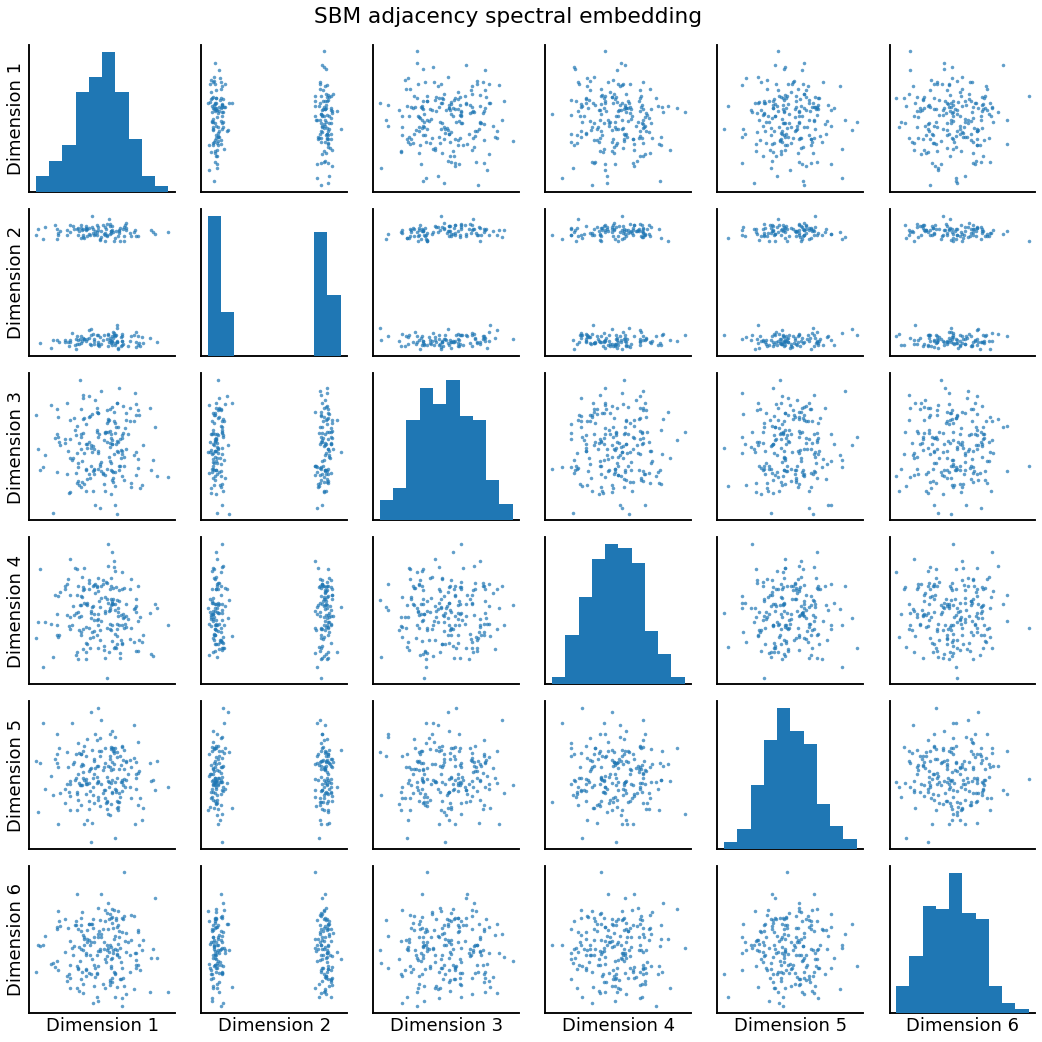

In [10]:
ase = AdjacencySpectralEmbed()
Xhat = ase.fit_transform(undirected_sbm)
pairplot(Xhat, title='SBM adjacency spectral embedding')

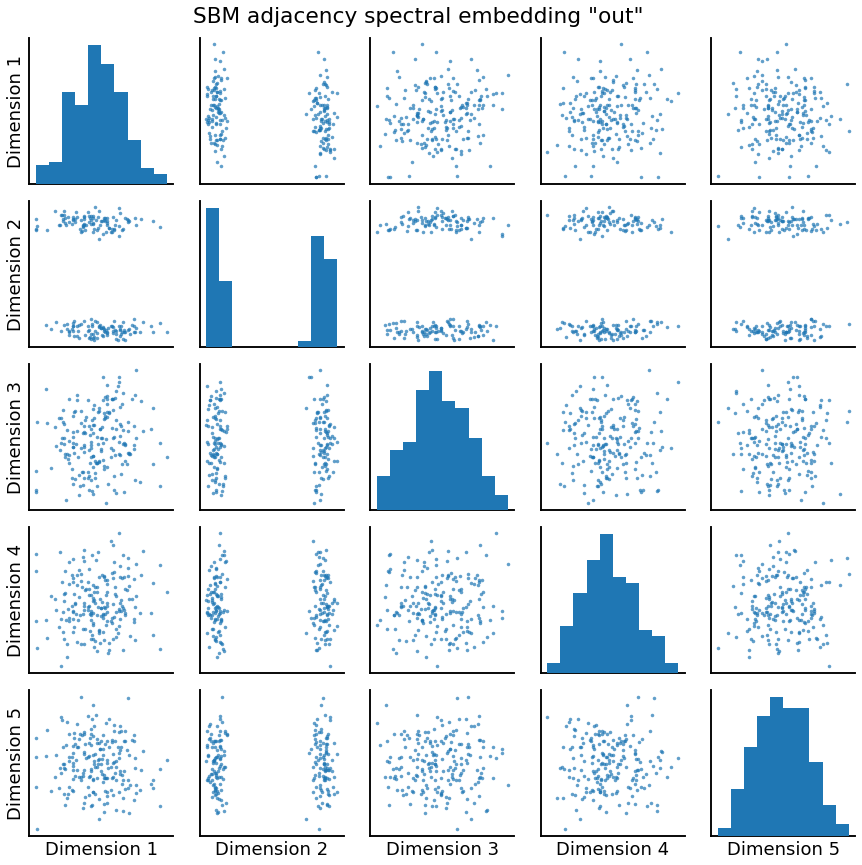

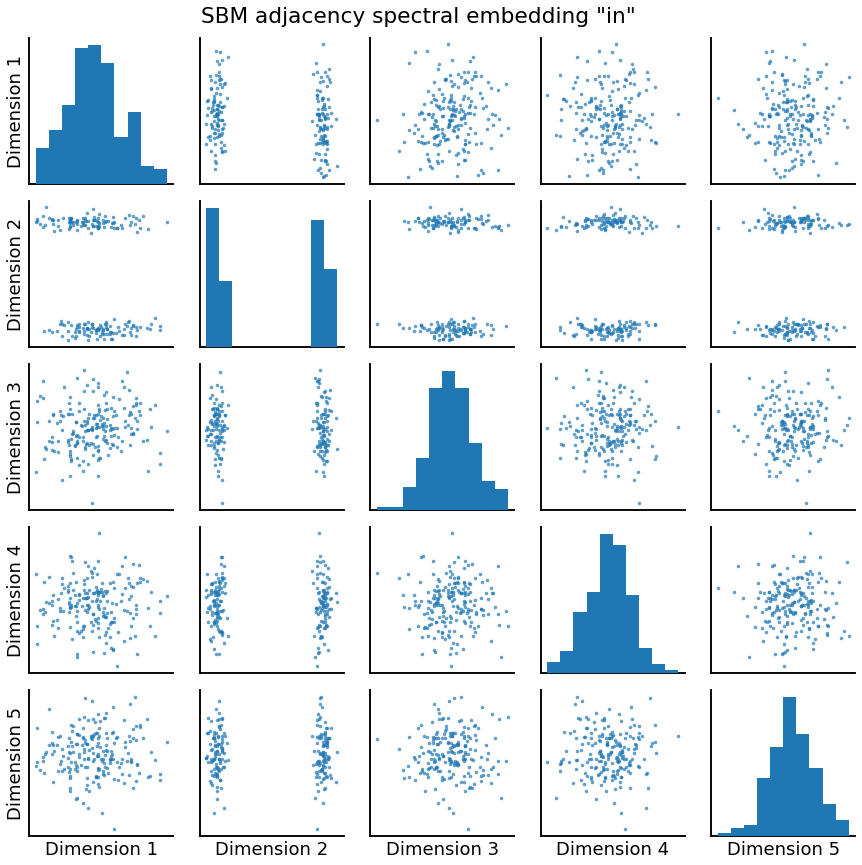

In [11]:
ase = AdjacencySpectralEmbed()
Xhat, Yhat = ase.fit_transform(directed_sbm)
pairplot(Xhat, title='SBM adjacency spectral embedding "out"')
pairplot(Yhat, title='SBM adjacency spectral embedding "in"')

# sparse

In [12]:
from scipy.sparse import csr_matrix
s_undirected_sbm = csr_matrix(undirected_sbm)
s_directed_sbm = csr_matrix(directed_sbm)

In [69]:
ase = AdjacencySpectralEmbed(algorithm='full')
Xhat = ase.fit_transform(s_undirected_sbm)
pairplot(Xhat, title='SBM adjacency spectral embedding')

TypeError: 'full' agorithm does not support scipy.sparse.csr_matrix inputs.

/Users/asaadeldin/Downloads/GitHub/graspologic/graspologic/embed/ase.py:154: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.get_lcc``.
  warnings.warn(msg, UserWarning)


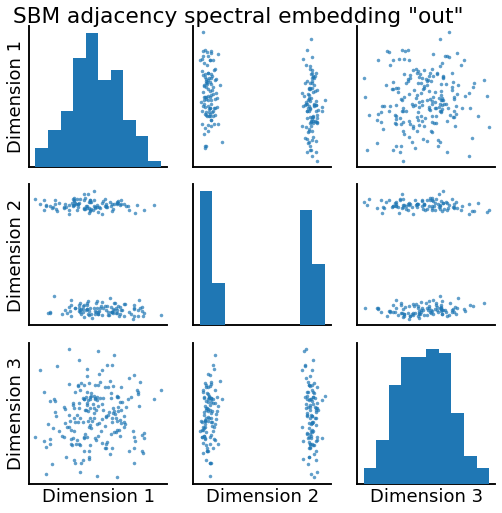

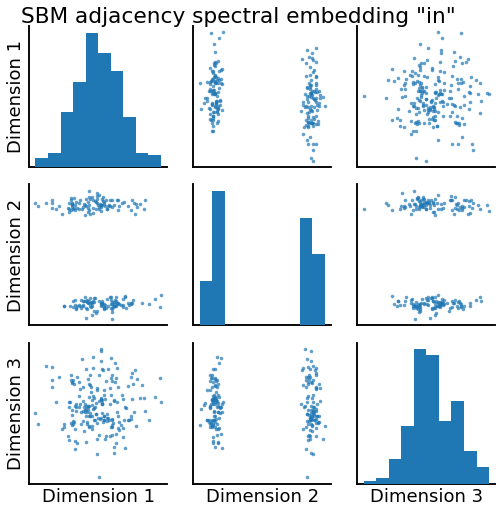

In [9]:
ase = AdjacencySpectralEmbed()
Xhat, Yhat = ase.fit_transform(s_directed_sbm)
pairplot(Xhat, title='SBM adjacency spectral embedding "out"')
pairplot(Yhat, title='SBM adjacency spectral embedding "in"')

# Check select_dimension

In [104]:
from graspologic.embed import select_dimension
from graspologic.utils import augment_diagonal

# Xhat.shape
augd = augment_diagonal(undirected_sbm)
print('not sparse: ', select_dimension(augd))

augd = augment_diagonal(s_undirected_sbm)
print('sparse: ', select_dimension(augd))


not sparse:  ([2, 6], [60.270048117794175, 10.775103395737059])
sparse:  ([2, 6], [60.27004811779412, 10.775103395737059])


# Check if mase works

In [89]:
from graspologic.simulations import sbm
from graspologic.embed import MultipleASE as MASE

n = [25, 25]
B1 = [[0.3, 0.1],
      [0.1, 0.7]]
B2 = [[0.3, 0.1],
      [0.1, 0.3]]

np.random.seed(8)
G1 = np.asarray(sbm(n, B1))
G2 = np.asarray(sbm(n, B2))
g = [G1,G2]
isinstance(g,list)
# mat = csr_matrix(g)
len(g)

embedder = MASE(n_components=2)
em = embedder.fit(g)
em.scores_

array([[[18.56245971, -2.25504526],
        [-2.25504526,  7.33274538]],

       [[ 9.95298859,  2.15244035],
        [ 2.15244035,  7.4807731 ]]])

In [92]:
np.random.seed(8)
G1 = csr_matrix(np.asarray(sbm(n, B1)))
G2 = csr_matrix(np.asarray(sbm(n, B2)))
g = [G1,G2]
isinstance(g,list)
# mat = csr_matrix(g)
len(g)

embedder = MASE(n_components=2)
em = embedder.fit(g)
em.scores_

array([[[18.56245971, -2.25504526],
        [-2.25504526,  7.33274538]],

       [[ 9.95298859,  2.15244035],
        [ 2.15244035,  7.4807731 ]]])

# OMNI

In [103]:
from graspologic.simulations import sbm
from graspologic.embed import OmnibusEmbed
from scipy.sparse import isspmatrix_csr
import scipy

np.random.seed(8)
G1 = csr_matrix(np.asarray(sbm(n, B1)))
G2 = csr_matrix(np.asarray(sbm(n, B2)))
g = [G1,G2]
# isinstance(g, scipy.sparse.csr.csr_matrix)
# mat = csr_matrix(g)
# len(g)
# any([isspmatrix_csr(gr) for gr in g])
embedder = OmnibusEmbed()
Zhat = embedder.fit_transform(g)



TypeError: OmnibusEmbed does not support scipy.sparse.csr_matrix inputs

# Proof sparse works faster

In [25]:
import time
n = [100, 500, 1000, 1500]
reps = 20
times = np.zeros((len(n),reps))
times_sparse = np.zeros((len(n),reps))
ase = AdjacencySpectralEmbed(check_lcc=False,algorithm='truncated', n_components=2)
for i, n_verts in enumerate(n):
    for j in range(reps):
        labels_sbm = n_verts * [0] + n_verts * [1]
        P = np.array([[0.8, 0.2], [0.2, 0.8]])
        undirected_sbm = sbm(2 * [n_verts], P)
        s_undirect_sbm = csr_matrix(undirected_sbm)
        start = time.time()
        Xhat = ase.fit_transform(undirected_sbm)
        times[i,j] = time.time()-start
        start = time.time()
        Xhat = ase.fit_transform(s_undirected_sbm)
        times_sparse[i,j] = time.time()-start


In [16]:
import numpy as np
# print(times)
# print(times_sparse)
avg = [np.mean(x) for x in times]
avg_sp = [np.mean(x) for x in times_sparse]
er = [2*sem(x) for x in times]
er_sp = [2*sem(x) for x in times_sparse]
print(avg)
print(avg_sp)

[0.014302027225494385, 0.15613011121749878, 0.713032579421997, 2.097516930103302]
[0.02682749032974243, 0.024235987663269044, 0.02827322483062744, 0.04278022050857544]


Text(0, 0.5, 'Time(s) (+/- 2*s.e.)')

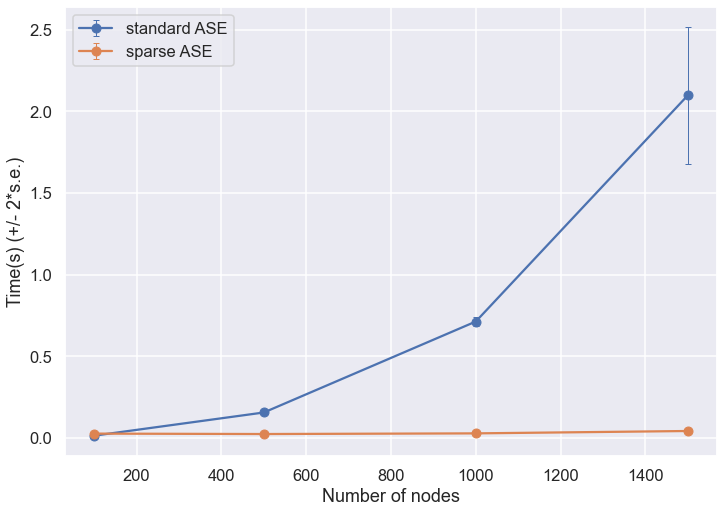

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context('talk')
sns.set
plt.errorbar(n,avg, er, label = 'standard ASE', marker='o',capsize=3, elinewidth=1, markeredgewidth=1)
plt.errorbar(n,avg_sp, er_sp, label = 'sparse ASE', marker='o',capsize=3, elinewidth=1, markeredgewidth=1)
plt.legend()
plt.xlabel('Number of nodes')
plt.ylabel('Time(s) (+/- 2*s.e.)')